# Lab 3 — dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib.colors import rgb2hex
from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [17]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.layouts import widgetbox

movies -> movieId, title, [genre]
tags -> tagId, tag
scores -> (movieId, tagId), relevance

In [3]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
ratings = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)
movie_index = scores.map(lambda x: x['movieId']).distinct().zipWithIndex().collectAsMap()

In [5]:
tags_local = tags.collect()

In [6]:
# print('Number of movies:', movies.count())
# print('Number of tags:', tags.count())
# print('Number of scores:', scores.count())
# print('Number of ratings:', ratings.count())

## 3.1
Construct MxN matrix, where N=1128 - tagId, M=10381 - movieId with at least one tag

In [7]:
sorted_scores = scores.map(lambda x: (x['movieId'], (x['tagId'], x['relevance']))).groupByKey().sortByKey().collect()

In [8]:
matrix = np.zeros((tags.count(), len(sorted_scores)))

In [9]:
for i in range(len(sorted_scores)):
    for j,r in sorted_scores[i][1]:
        matrix[j-1][i] = r

Plot the variance of each dimension (represented by tags) across all movies.

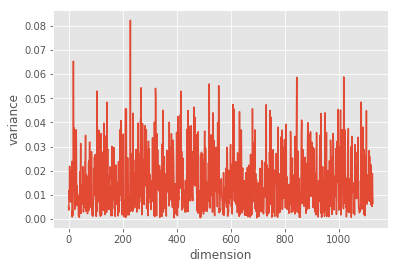

In [15]:
plt.xlabel("dimension")
plt.ylabel("variance")
plt.plot(np.var(matrix, axis=1))

Plot the eigenvalues of the M × M covariance matrix.

In [11]:
matrixCov = np.cov(matrix)

In [12]:
vals, vecs = np.linalg.eigh(matrixCov)

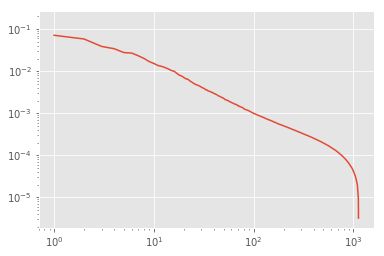

In [13]:
vl = vals.tolist()
vl.reverse()
vl /= vals.sum()
plt.loglog(vl)

Explain the implications for dimensionality reduction:<br>
Dimensionality reduction aims at explaining data by looking only at parts of it. To accurately classify the data, we need to look at the relations that give us the most information. In this case, the importance of relations is given in the eigenvalues of the covariance matrix. 

Hhow many principal directions do you need to capture 2/3 of the variability in
the data?

In [22]:
vc = np.cumsum(vl)
print('Principal components to capture 2/3:', len(vc[vc <= 2/3])+1)

Principal components to capture 2/3: 37


## 3.2 Concept Space

For the five first principal directions, find the 10 tags that have the highest and lowest
coordinates in that direction.

In [14]:
top_eigvecs = vecs[:-6:-1]

In [62]:
k = 1
for vec in top_eigvecs:
    print('Eigenvector', k)
    ix = np.argsort(vec)
    print('Top tags')
    for i in ix[:10]:
        print(tags_local[i+1]['tag'], end=', ')
    print('\nLow tags')
    for i in ix[:-11:-1]:
        print(tags_local[i+1]['tag'], end=', ')
    print('\n')
    k += 1

Eigenvector 1
Top tags
art house, bad ending, atmospheric, bad acting, suspense, arnold, artificial intelligence, snakes, business, spaghetti western, 
Low tags
atheism, based on a play, bad, awesome soundtrack, propaganda, san francisco, best of 2005, caper, beautiful, author:neil gaiman, 

Eigenvector 2
Top tags
atheism, bad, based on a play, awesome soundtrack, author:neil gaiman, beautiful, australia, circus, best of 2005, based on a book, 
Low tags
art house, bad ending, atmospheric, bad acting, author:alan moore, arnold, assassins, argentina, artificial intelligence, boring!, 

Eigenvector 3
Top tags
assassination, astronauts, bad cgi, bad script, autism, ballet, based on a video game, assassins, wilderness, based on comic, 
Low tags
bad ending, bad acting, bad science, australian, atmospheric, awesome soundtrack, awesome, author:alan moore, wedding, artistic, 

Eigenvector 4
Top tags
colourful, chicago, depressing, cool, entertaining, fun movie, computer animation, computer game

What concepts would you use to describe these dimensions?
### TODO

Create a Python dict which maps every tag (name) to its coordinates in the 5 first principal
directions and save it to disk.

In [25]:
dictionary = {}
for i in range(len(top_eigvecs[0])):
    dirs = []
    for vec in top_eigvecs:
        dirs.append(vec[i])
    dictionary[tags_local[i]['tag']] = dirs

In [26]:
pickle.dump(dictionary, open('tagsPCA.pickle', 'wb'))

## 3.3 Movie visualization

In [4]:
with open('selected-movies.pickle', 'rb') as file:
    selected_movies = pickle.load(file, encoding='utf-8')

In [15]:
d = dict(x=[], y=[], name=[], score=[], color=[])

for movie in selected_movies:
    coords = matrix.T[movie_index[movie[0]]] @ top_eigvecs[:2,:].T
    d['x'].append(coords[0])
    d['y'].append(coords[1])
    d['name'].append(movie[1])
    d['score'].append(movie[2])
    d['color'].append(rgb2hex(plt.get_cmap('RdYlGn')(movie[2])[:3]))
    
src = ColumnDataSource(d)
hover = HoverTool(
        tooltips=[
            ("name", "@name"),
            ("tomato score","@score"),
        ]
    )

p = figure(tools=[hover], title="Movies scores",x_axis_label='bad movies - good movies',y_axis_label='action - sentimental')

p.circle('x', 'y', size=20, source=src, color='color')
output_file("dimred.html")
show(p)

In [18]:
import IPython
IPython.display.HTML(filename="dimred.html")